<a href="https://colab.research.google.com/github/naenumtou/dataScienceLab/blob/main/customerCohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/onlineRetail

/content/drive/My Drive/Colab Notebooks/onlineRetail


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

# Config 
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style

In [4]:
# Import data
df = pd.read_csv(
    'onlineRetailClean.csv',
    dtype = {
        'Invoice': str,
        'StockCode': str,
        'Description': str,
        'Quantity': np.float64,
        'Price': np.float64,
        'Customer ID': str,
        'Country': str,
        'TotalPrice': np.float64
    },
    parse_dates = ['InvoiceDate']
)

# Create 'InvoiceMonth' from 'InvoiceDate'
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp('M') #Convert back to 'datetime64[ns]'

# Remove testing product
df = df[~df['StockCode'].isin(['TEST001', 'TEST002'])]

# Show table
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2018-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2018-12-31
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2018-12-31
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2018-12-31
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2018-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2018-12-31
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2018-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2018-12-31


In [5]:
# Create first transaction on each customer
df['cohortMonth'] = df.groupby(['Customer ID'])['InvoiceMonth'].transform('min')

# Show table
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,InvoiceMonth,cohortMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2018-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2018-12-31,2018-12-31
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2018-12-31,2018-12-31
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2018-12-31,2018-12-31
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2018-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2018-12-31,2018-12-31
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2018-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2018-12-31,2018-12-31


In [6]:
# Create time offset in month interval
df['cohortIndex'] = round((df['InvoiceMonth'] - df['cohortMonth']) / np.timedelta64(1, 'M')) + 1

# Show table
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,InvoiceMonth,cohortMonth,cohortIndex
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2018-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2018-12-31,2018-12-31,1.0
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2018-12-31,2018-12-31,1.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2018-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2018-12-31,2018-12-31,1.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2018-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2018-12-31,2018-12-31,1.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2018-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2018-12-31,2018-12-31,1.0


In [7]:
# Count unique customer per period
dfCohort = df.groupby(
    ['cohortMonth', 'cohortIndex'],
    as_index = False
)['Customer ID'].nunique()

# Show table
dfCohort.head(5)

,cohortMonth,cohortIndex,Customer ID
0,2018-12-31,1.0,954
1,2018-12-31,2.0,336
2,2018-12-31,3.0,319
3,2018-12-31,4.0,405
4,2018-12-31,5.0,363


In [8]:
# Create pivot table
dfCohort = pd.pivot_table(
    dfCohort,
    values = 'Customer ID',
    index = ['cohortMonth'],
    columns = ['cohortIndex']
)

# Show table
dfCohort.head(5)

cohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0
cohortMonth,,,,,,,,,,,,,,,,,,,,,
2018-12-31,954.0,336.0,319.0,405.0,363.0,343.0,359.0,327.0,321.0,346.0,...,289.0,251.0,289.0,270.0,248.0,244.0,301.0,291.0,389.0,188.0
2019-01-31,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,...,58.0,90.0,76.0,71.0,75.0,93.0,74.0,94.0,22.0,NaN
2019-02-28,374.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,...,75.0,60.0,61.0,54.0,86.0,86.0,61.0,22.0,NaN,NaN
2019-03-31,444.0,84.0,102.0,108.0,103.0,90.0,109.0,134.0,122.0,48.0,...,75.0,77.0,69.0,78.0,89.0,94.0,35.0,NaN,NaN,NaN
2019-04-30,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,31.0,32.0,...,46.0,41.0,44.0,53.0,66.0,17.0,NaN,NaN,NaN,NaN


In [9]:
# Calculate retention rate
dfCohort = dfCohort.divide(dfCohort.iloc[:, 0], axis = 0) #Divide by initial

# Show table
dfCohort.head(5)

cohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0
cohortMonth,,,,,,,,,,,,,,,,,,,,,
2018-12-31,1.0,0.352201,0.334382,0.424528,0.380503,0.359539,0.376310,0.342767,0.336478,0.362683,...,0.302935,0.263103,0.302935,0.283019,0.259958,0.255765,0.315514,0.305031,0.407757,0.197065
2019-01-31,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,...,0.151436,0.234987,0.198433,0.185379,0.195822,0.242820,0.193211,0.245431,0.057441,NaN
2019-02-28,1.0,0.237968,0.224599,0.291444,0.245989,0.200535,0.192513,0.286096,0.254011,0.275401,...,0.200535,0.160428,0.163102,0.144385,0.229947,0.229947,0.163102,0.058824,NaN,NaN
2019-03-31,1.0,0.189189,0.229730,0.243243,0.231982,0.202703,0.245495,0.301802,0.274775,0.108108,...,0.168919,0.173423,0.155405,0.175676,0.200450,0.211712,0.078829,NaN,NaN,NaN
2019-04-30,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.105442,0.108844,...,0.156463,0.139456,0.149660,0.180272,0.224490,0.057823,NaN,NaN,NaN,NaN


In [10]:
# Define plot matrix function
def plotTable(data, plotName, percent = True):
  plt.figure(figsize = (21, 9))
  plt.title(f'{plotName}')
  if percent:
    format = '.2%'
  else:
    format = '.2f'
  ax = sns.heatmap(
      data,
      annot = True,
      fmt = format,
      xticklabels = True,
      yticklabels = True,
      cmap = 'Blues',
      cbar = False
  )
  ax.set_xticklabels(data.columns.astype(int))
  ax.set_yticklabels(data.index.strftime('%Y-%m'))
  return plt.show()

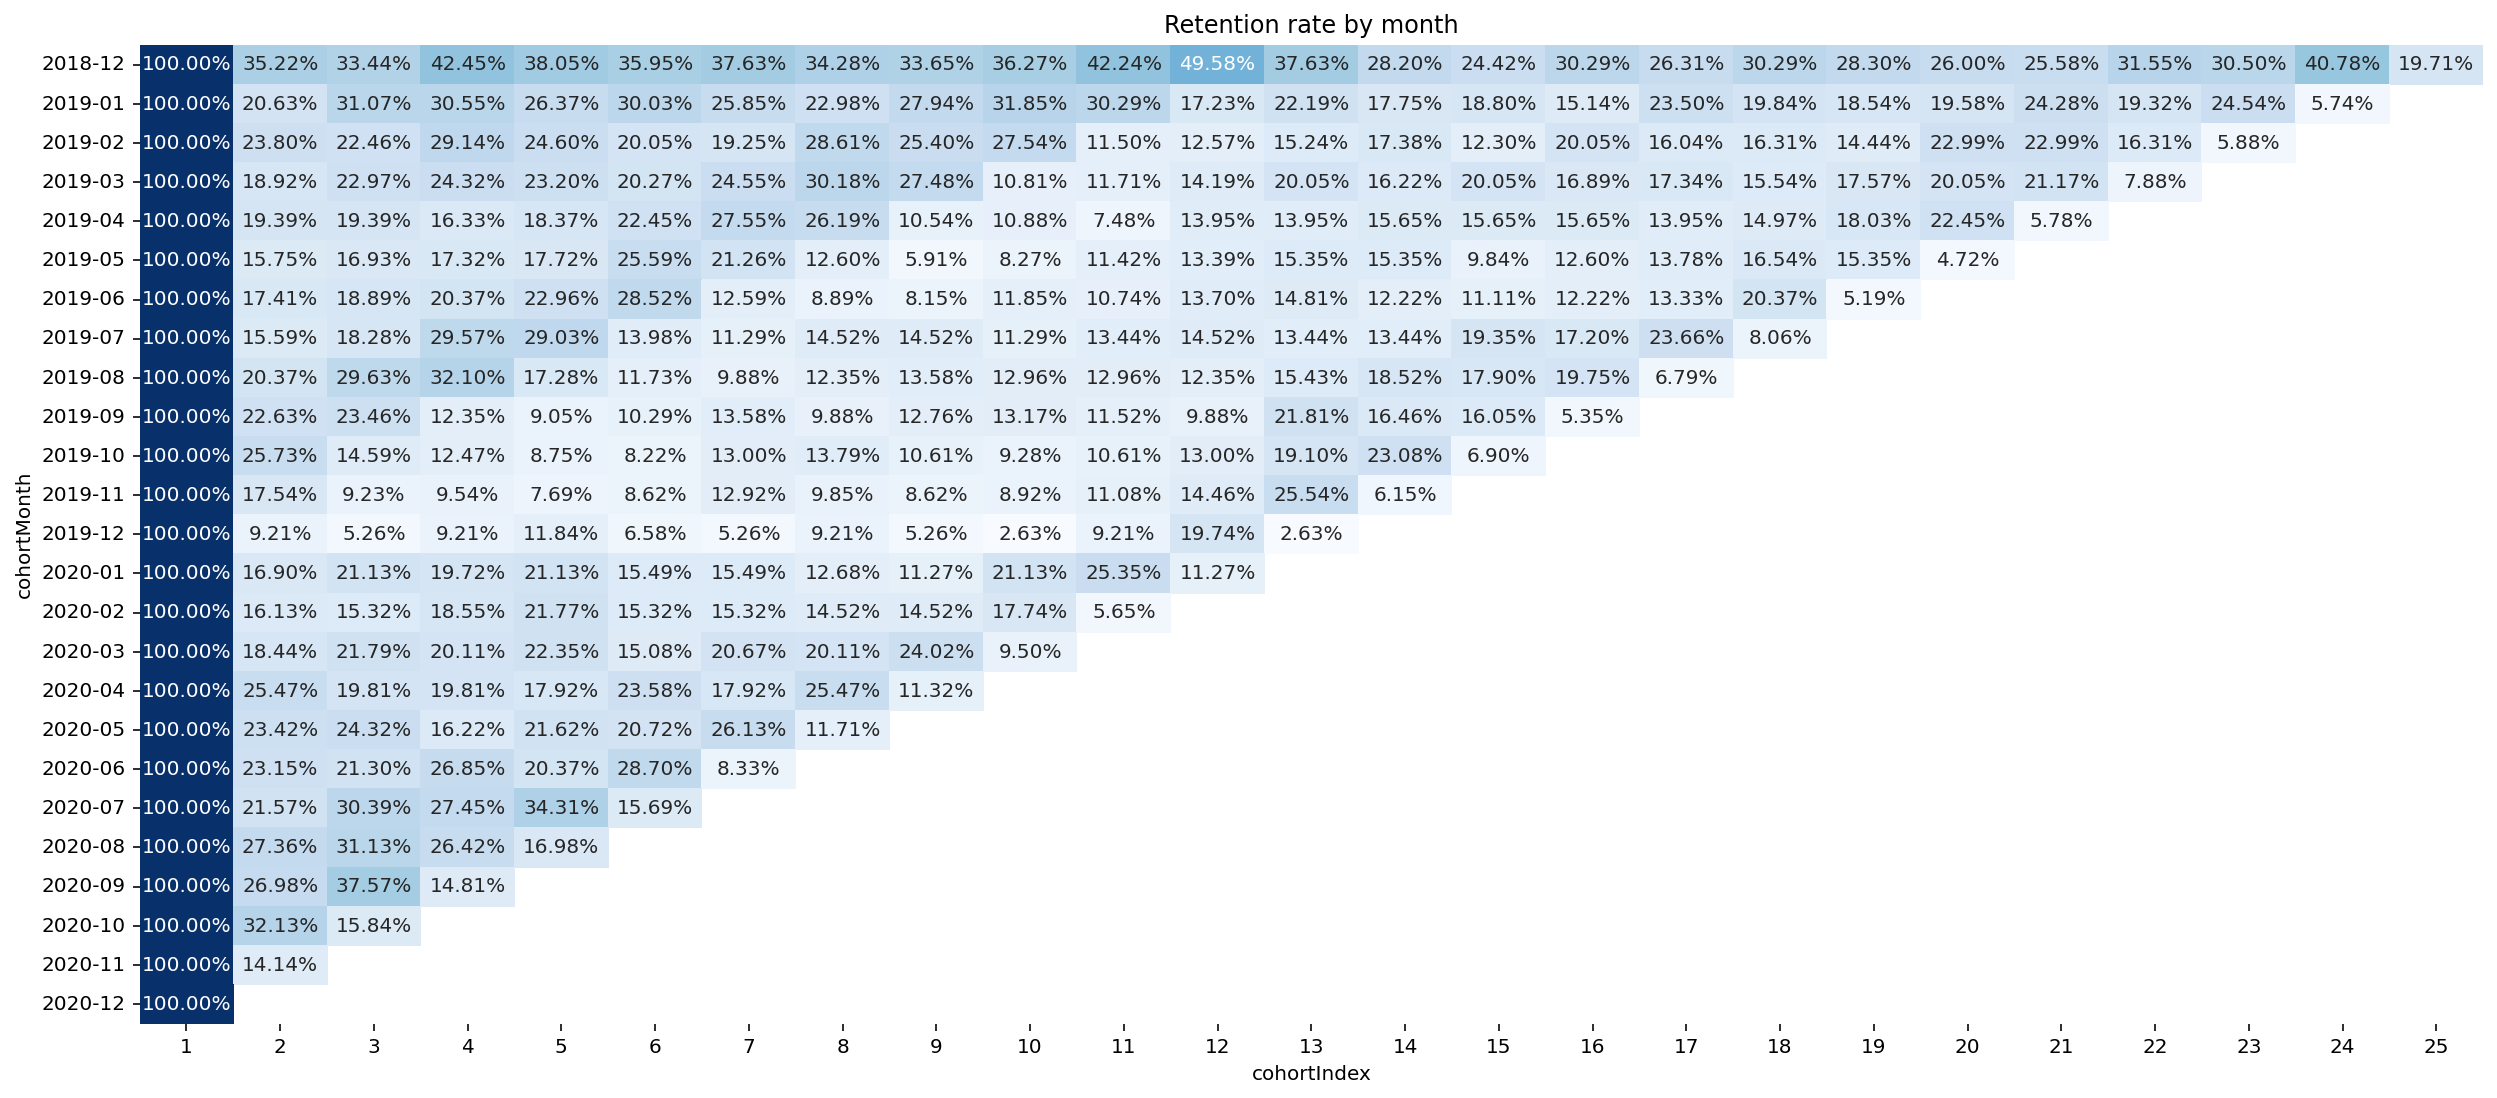

In [11]:
# Plot
plotTable(dfCohort, 'Retention rate by month')

In [12]:
# Average spending price per period
df['TotalSale'] = df['Price'] * df['Quantity'] #Calculation total sale
dfPrice = df.groupby(
    ['cohortMonth', 'cohortIndex'],
    as_index = False
)['TotalSale'].mean()

dfPrice = pd.pivot_table(
    dfPrice,
    values = 'TotalSale',
    index = ['cohortMonth'],
    columns = ['cohortIndex']
) # Pivot

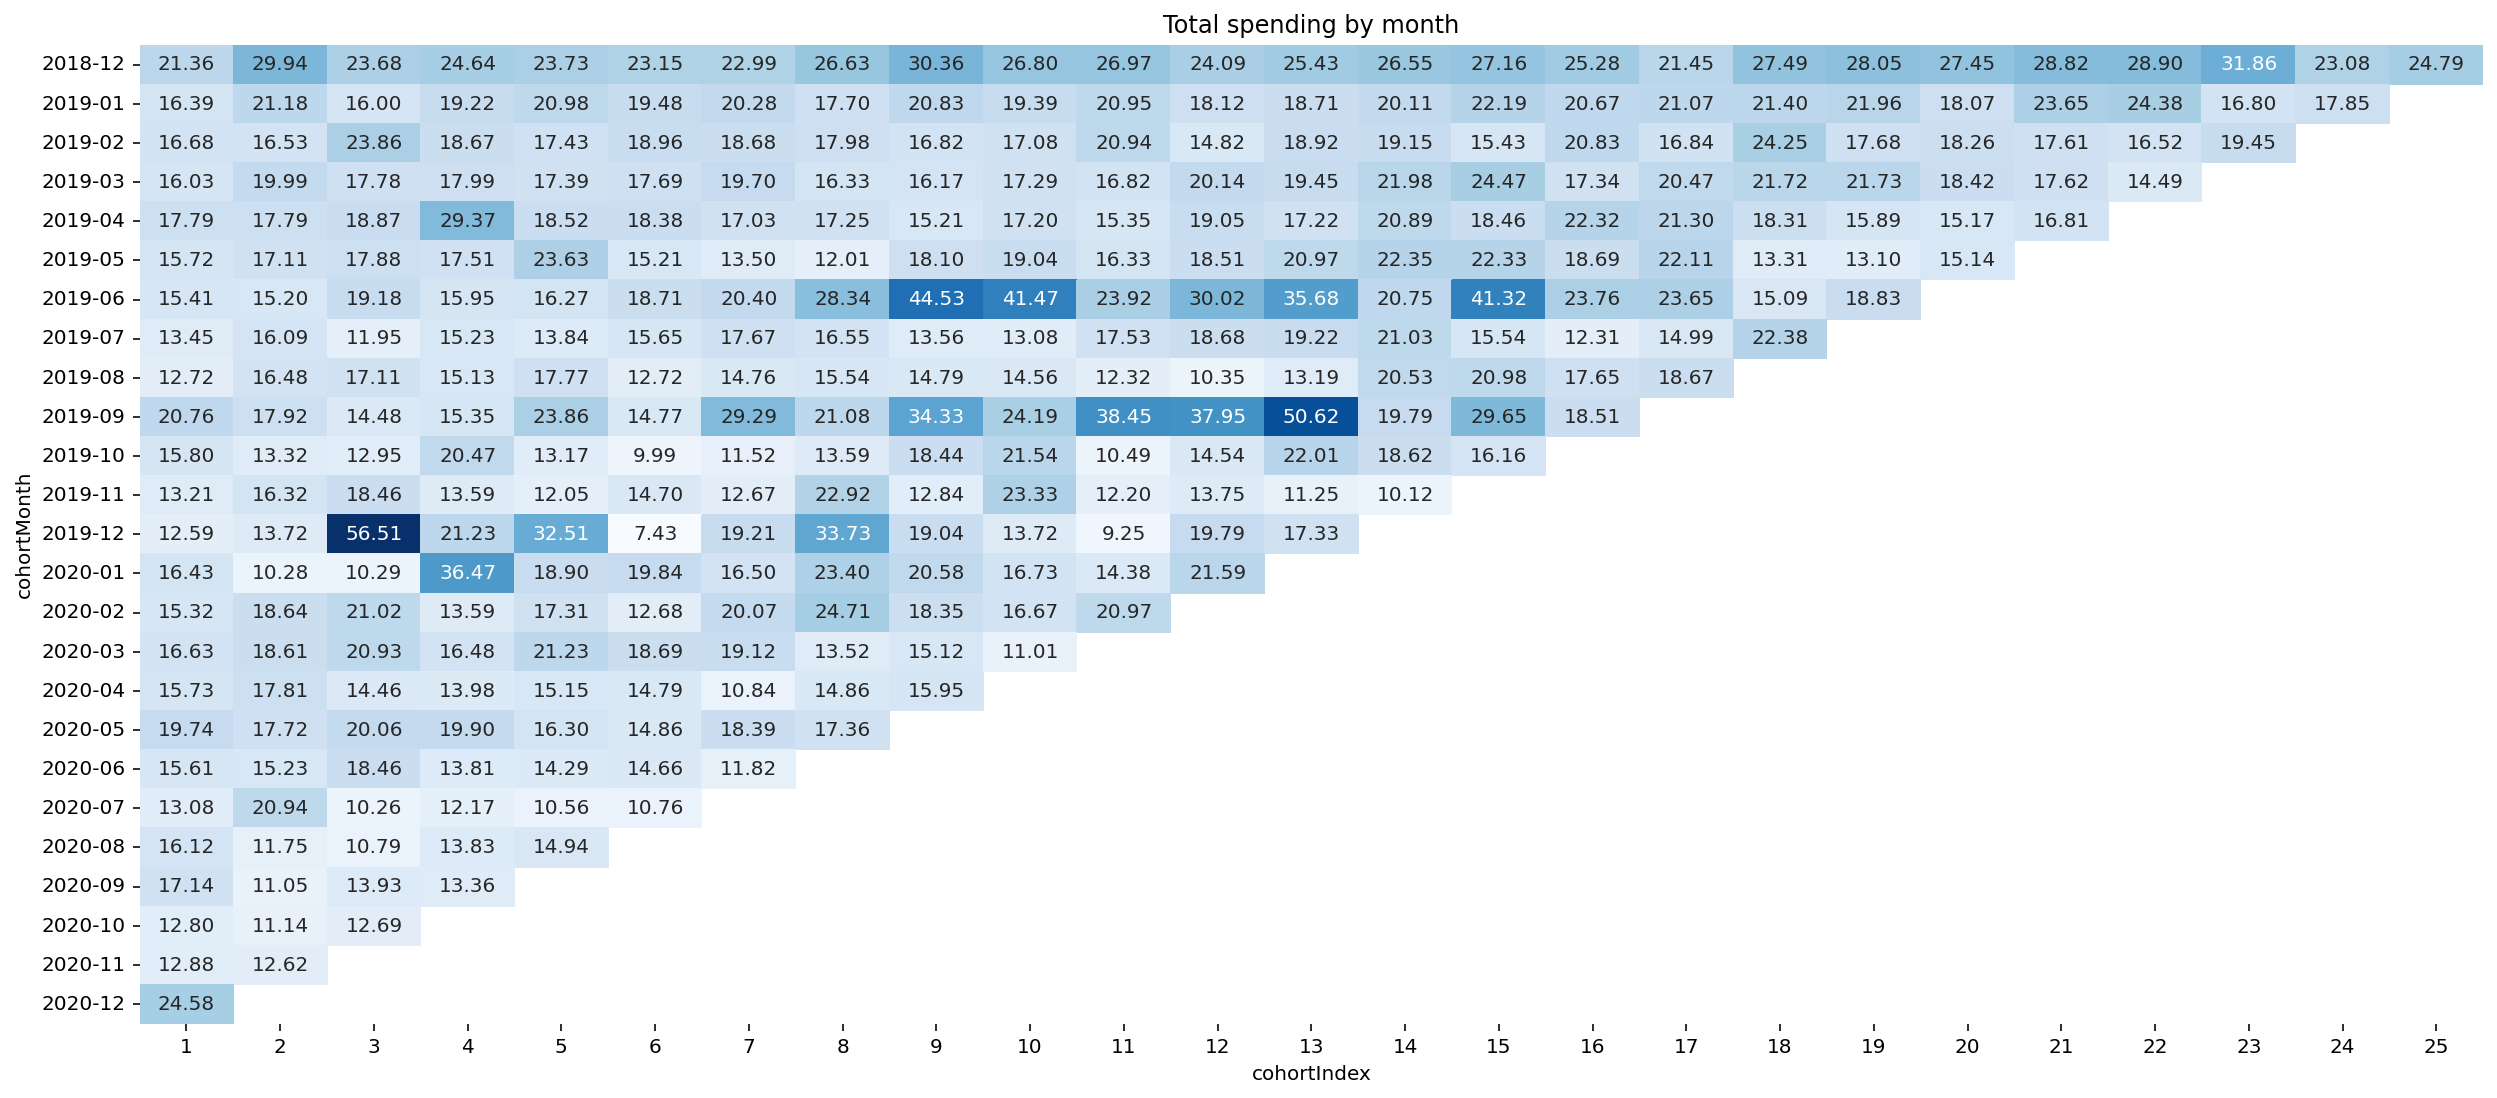

In [13]:
# Plot
plotTable(dfPrice, 'Total spending by month', percent = False)